In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# raw_dataset = pd.read_csv("/data/fast0/datasets/glathida-3.1.0/data/T.csv")
raw_dataset = pd.read_csv("~/data/glac/TTT.csv")
# raw_dataset = pd.read_csv("~/stuff/coding/glacier/glac/data/TTT.csv")

dataset = raw_dataset.copy()

#examine missing data
dataset.head()

2.6.0


/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (2,4,5,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,GlaThiDa_ID,POLITICAL_UNIT,GLACIER_NAME,SURVEY_DATE,PROFILE_ID,POINT_ID,POINT_LAT,POINT_LON,ELEVATION,THICKNESS,THICKNESS_UNCERTAINTY,DATA_FLAG,REMARKS
0,33,US,EASTON,19929999.0,NaN,1.0,48.767380,-121.819644,2962.0,0,NaN,NaN,NaN
1,33,US,EASTON,19929999.0,NaN,2.0,48.764904,-121.821909,2813.0,29,NaN,NaN,NaN
2,33,US,EASTON,19929999.0,NaN,3.0,48.761662,-121.825264,2598.0,41,NaN,NaN,NaN
3,33,US,EASTON,19929999.0,NaN,4.0,48.757063,-121.829107,2383.0,71,NaN,NaN,NaN
4,33,US,EASTON,19929999.0,NaN,5.0,48.753715,-121.832006,2284.0,82,NaN,NaN,NaN


In [2]:
#drop everything but lat, long, elevation, thickness

dataset = dataset.drop("GlaThiDa_ID", axis=1)
dataset = dataset.drop("POLITICAL_UNIT", axis=1)
dataset = dataset.drop("GLACIER_NAME", axis=1)
dataset = dataset.drop("SURVEY_DATE", axis=1)
dataset = dataset.drop("PROFILE_ID", axis=1)
dataset = dataset.drop("POINT_ID", axis=1)
dataset = dataset.drop("THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("DATA_FLAG", axis=1)
dataset = dataset.drop("REMARKS", axis=1)

#sum up rows with empty cells
dataset = dataset.dropna()
dataset.isna().sum()

POINT_LAT    0
POINT_LON    0
ELEVATION    0
THICKNESS    0
dtype: int64

In [3]:
dataset

,POINT_LAT,POINT_LON,ELEVATION,THICKNESS
0,48.767380,-121.819644,2962.0,0
1,48.764904,-121.821909,2813.0,29
2,48.761662,-121.825264,2598.0,41
3,48.757063,-121.829107,2383.0,71
4,48.753715,-121.832006,2284.0,82
...,...,...,...,...
3854274,47.092690,12.380504,3329.0,36
3854275,47.093780,12.379642,3353.0,26
3854276,47.094839,12.378200,3381.0,39
3854277,47.094829,12.378174,3381.0,39


In [4]:
#split the dataset and reserve some to test what was trained.
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

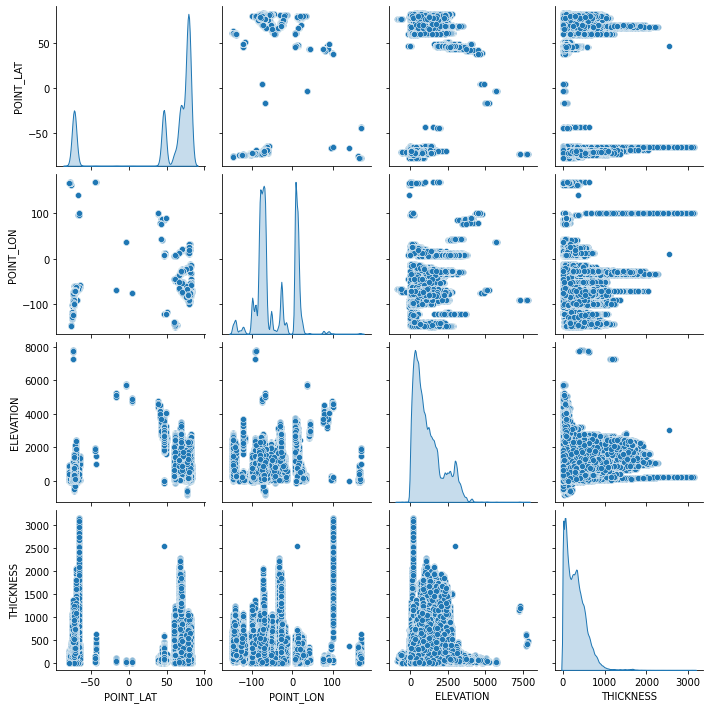

In [5]:
sns.pairplot(train_dataset[["POINT_LAT", "POINT_LON", "ELEVATION", "THICKNESS"]], diag_kind='kde')

In [6]:
#separate out features - what will be trained to predict desired attribute
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop("THICKNESS")
test_labels = test_features.pop("THICKNESS")

train_features.describe().transpose()[['mean', 'std']]

,mean,std
POINT_LAT,47.477816,53.238428
POINT_LON,-46.458083,45.484560
ELEVATION,1175.033891,937.446613


In [7]:
#establish normalization layers
normalizer = {}
variable_list = ("POINT_LAT", "POINT_LON", "ELEVATION")
for variable_name in variable_list:

    normalizer[variable_name] = preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = preprocessing.Normalization(axis=-1)
normalizer['ALL'].adapt(np.array(train_features))

In [8]:
def build_linear_model(normalizer):
    model = tf.keras.Sequential([
        normalizer,
        layers.Dense(1)
    ])

    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        loss="mean_absolute_error")
    
    return model

def plot_single_model_variable(x, y,feature_name):
    plt.scatter(train_features[feature_name], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel(feature_name)
    plt.ylabel("Avg Thickness (m)")
#     plt.xlim((0,20))
    plt.legend()
      
def plot_loss(history):
#     plt.subplots(figsize=(10,5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #   plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    

In [9]:
test_results = {}
linear_model = {}
linear_history = {}
linear_results = {}

In [12]:
%%time
variable_list = ("POINT_LAT", "POINT_LON", "ELEVATION")
for variable_name in variable_list:

    linear_model[variable_name] = build_linear_model(normalizer[variable_name])
    linear_history[variable_name] = linear_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=100,
#                                         verbose=0,
                                        validation_split = 0.2)
    linear_results[variable_name] = linear_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

linear_results

Epoch 1/100
67457/67457 [==============================] - 39s 568us/step - loss: 186.2128 - val_loss: 184.8752
Epoch 2/100
67457/67457 [==============================] - 35s 523us/step - loss: 184.5718 - val_loss: 184.8840
Epoch 3/100
67457/67457 [==============================] - 36s 531us/step - loss: 184.5676 - val_loss: 184.8920
Epoch 4/100
67457/67457 [==============================] - 34s 501us/step - loss: 184.5698 - val_loss: 184.8916
Epoch 5/100
67457/67457 [==============================] - 31s 463us/step - loss: 184.5704 - val_loss: 184.8797
Epoch 6/100
67457/67457 [==============================] - 31s 458us/step - loss: 184.5709 - val_loss: 184.8846
Epoch 7/100
67457/67457 [==============================] - 34s 509us/step - loss: 184.5706 - val_loss: 184.8852
Epoch 8/100
67457/67457 [==============================] - 39s 578us/step - loss: 184.5702 - val_loss: 184.8920
Epoch 9/100
67457/67457 [==============================] - 39s 575us/step - loss: 184.5721 - val_loss: 1

67457/67457 [==============================] - 32s 473us/step - loss: 184.5688 - val_loss: 184.8761
Epoch 74/100
67457/67457 [==============================] - 31s 460us/step - loss: 184.5702 - val_loss: 184.8760
Epoch 75/100
67457/67457 [==============================] - 35s 523us/step - loss: 184.5693 - val_loss: 184.8829
Epoch 76/100
67457/67457 [==============================] - 33s 483us/step - loss: 184.5685 - val_loss: 184.8789
Epoch 77/100
67457/67457 [==============================] - 30s 442us/step - loss: 184.5719 - val_loss: 184.8804
Epoch 78/100
67457/67457 [==============================] - 28s 416us/step - loss: 184.5711 - val_loss: 184.8757
Epoch 79/100
67457/67457 [==============================] - 31s 462us/step - loss: 184.5720 - val_loss: 184.8880
Epoch 80/100
67457/67457 [==============================] - 34s 505us/step - loss: 184.5713 - val_loss: 184.8734
Epoch 81/100
67457/67457 [==============================] - 34s 506us/step - loss: 184.5689 - val_loss: 184.8

67457/67457 [==============================] - 36s 528us/step - loss: 166.4763 - val_loss: 166.7547
Epoch 46/100
67457/67457 [==============================] - 95s 1ms/step - loss: 166.4755 - val_loss: 166.7594
Epoch 47/100
67457/67457 [==============================] - 40s 600us/step - loss: 166.4750 - val_loss: 166.7561
Epoch 48/100
67457/67457 [==============================] - 40s 598us/step - loss: 166.4738 - val_loss: 166.7571
Epoch 49/100
67457/67457 [==============================] - 37s 551us/step - loss: 166.4756 - val_loss: 166.7532
Epoch 50/100
67457/67457 [==============================] - 31s 463us/step - loss: 166.4760 - val_loss: 166.7755
Epoch 51/100
67457/67457 [==============================] - 29s 429us/step - loss: 166.4751 - val_loss: 166.7623
Epoch 52/100
67457/67457 [==============================] - 33s 492us/step - loss: 166.4751 - val_loss: 166.7662
Epoch 53/100
67457/67457 [==============================] - 33s 495us/step - loss: 166.4753 - val_loss: 166.771

67457/67457 [==============================] - 31s 456us/step - loss: 175.1627 - val_loss: 175.3599
Epoch 18/100
67457/67457 [==============================] - 36s 532us/step - loss: 175.1617 - val_loss: 175.3588
Epoch 19/100
67457/67457 [==============================] - 33s 484us/step - loss: 175.1618 - val_loss: 175.3670
Epoch 20/100
67457/67457 [==============================] - 36s 533us/step - loss: 175.1615 - val_loss: 175.3677
Epoch 21/100
67457/67457 [==============================] - 34s 509us/step - loss: 175.1614 - val_loss: 175.3616
Epoch 22/100
67457/67457 [==============================] - 29s 427us/step - loss: 175.1622 - val_loss: 175.3794
Epoch 23/100
67457/67457 [==============================] - 34s 501us/step - loss: 175.1608 - val_loss: 175.3637
Epoch 24/100
67457/67457 [==============================] - 42s 619us/step - loss: 175.1614 - val_loss: 175.3626
Epoch 25/100
67457/67457 [==============================] - 37s 541us/step - loss: 175.1631 - val_loss: 175.3

67457/67457 [==============================] - 29s 434us/step - loss: 175.1616 - val_loss: 175.3829
Epoch 90/100
67457/67457 [==============================] - 27s 404us/step - loss: 175.1617 - val_loss: 175.3594
Epoch 91/100
67457/67457 [==============================] - 27s 405us/step - loss: 175.1621 - val_loss: 175.3645
Epoch 92/100
67457/67457 [==============================] - 27s 407us/step - loss: 175.1616 - val_loss: 175.3617
Epoch 93/100
67457/67457 [==============================] - 27s 406us/step - loss: 175.1597 - val_loss: 175.3611
Epoch 94/100
67457/67457 [==============================] - 27s 405us/step - loss: 175.1612 - val_loss: 175.3644
Epoch 95/100
67457/67457 [==============================] - 27s 406us/step - loss: 175.1612 - val_loss: 175.3727
Epoch 96/100
67457/67457 [==============================] - 27s 404us/step - loss: 175.1611 - val_loss: 175.3630
Epoch 97/100
67457/67457 [==============================] - 27s 405us/step - loss: 175.1611 - val_loss: 175.3

{'POINT_LAT': 184.55911254882812,
 'POINT_LON': 166.42044067382812,
 'ELEVATION': 174.9431610107422}

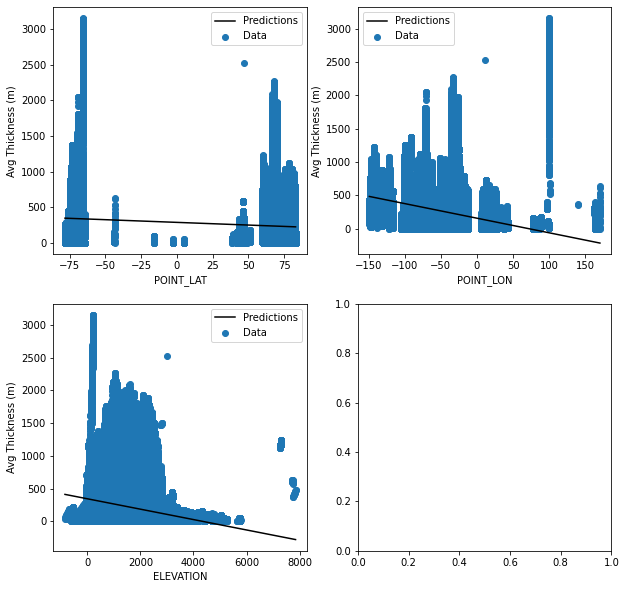

In [13]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(2,2,i+1)
    xmax = np.max(train_features[variable_name])
    xmin = np.min(train_features[variable_name])
    x = tf.linspace(xmin, xmax, 101)
    y = linear_model[variable_name].predict(x)
    plot_single_model_variable(x,y,variable_name)

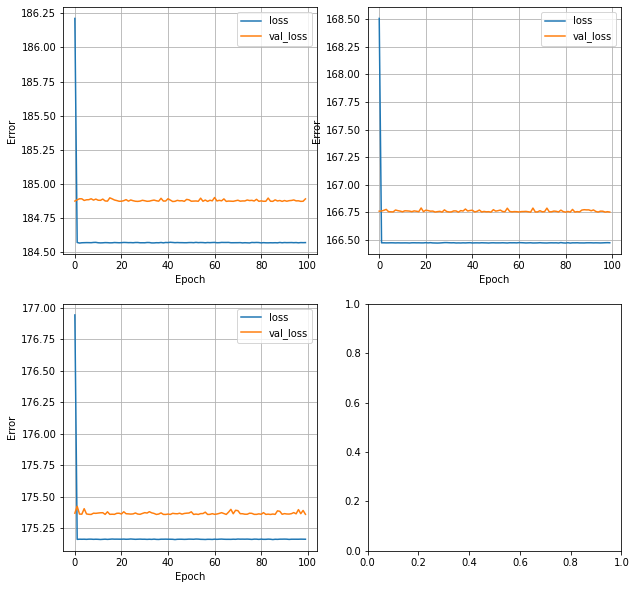

In [14]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(2,2,i+1)
    plot_loss(linear_history[variable_name])

In [15]:
%%time
linear_model = build_linear_model(normalizer['ALL'])

history = linear_model.fit(
train_features, train_labels,        
   epochs=100,
#    verbose=0,
   validation_split = 0.2)

test_results["MULTI"] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

Epoch 1/100
67457/67457 [==============================] - 27s 402us/step - loss: 164.6544 - val_loss: 162.8779
Epoch 2/100
67457/67457 [==============================] - 27s 402us/step - loss: 162.6037 - val_loss: 162.8965
Epoch 3/100
67457/67457 [==============================] - 28s 408us/step - loss: 162.6040 - val_loss: 162.8847
Epoch 4/100
67457/67457 [==============================] - 28s 408us/step - loss: 162.6041 - val_loss: 162.8751
Epoch 5/100
67457/67457 [==============================] - 32s 470us/step - loss: 162.6020 - val_loss: 162.8790
Epoch 6/100
67457/67457 [==============================] - 28s 417us/step - loss: 162.6059 - val_loss: 162.8852
Epoch 7/100
67457/67457 [==============================] - 28s 410us/step - loss: 162.6041 - val_loss: 162.9192
Epoch 8/100
67457/67457 [==============================] - 28s 412us/step - loss: 162.6039 - val_loss: 162.8900
Epoch 9/100
67457/67457 [==============================] - 27s 405us/step - loss: 162.6056 - val_loss: 1

67457/67457 [==============================] - 28s 411us/step - loss: 162.6044 - val_loss: 162.8788
Epoch 74/100
67457/67457 [==============================] - 55s 822us/step - loss: 162.6029 - val_loss: 162.8945
Epoch 75/100
67457/67457 [==============================] - 27s 403us/step - loss: 162.6051 - val_loss: 162.8972
Epoch 76/100
67457/67457 [==============================] - 27s 406us/step - loss: 162.6041 - val_loss: 162.8765
Epoch 77/100
67457/67457 [==============================] - 29s 424us/step - loss: 162.6058 - val_loss: 162.8769
Epoch 78/100
67457/67457 [==============================] - 30s 441us/step - loss: 162.6052 - val_loss: 162.8835
Epoch 79/100
67457/67457 [==============================] - 29s 433us/step - loss: 162.6055 - val_loss: 162.8990
Epoch 80/100
67457/67457 [==============================] - 32s 476us/step - loss: 162.6053 - val_loss: 162.8919
Epoch 81/100
67457/67457 [==============================] - 29s 426us/step - loss: 162.6039 - val_loss: 162.9

{'MULTI': 162.405517578125}

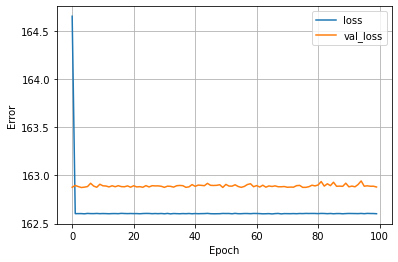

In [16]:
plot_loss(history)

In [17]:
def build_dnn_model(norm):
    model = keras.Sequential([
              norm,
              layers.Dense(64, activation='relu'),
              layers.Dense(64, activation='relu'),
              layers.Dense(1) ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
    
    return model

def dnn_test_results(feature_name):
    dnn_test_results[feature_name] = dnn_model.evaluate(
        test_features[feature_name],
        test_labels, verbose=0)

In [18]:
test_results = {}
dnn_model = {}
dnn_history = {}
dnn_results = {}

In [ ]:
%%time
variable_list = ("POINT_LAT", "POINT_LON", "ELEVATION")
for variable_name in variable_list:

    dnn_model[variable_name] = build_dnn_model(normalizer[variable_name])
    dnn_history[variable_name] = dnn_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=100,
#                                         verbose=0,
                                        validation_split = 0.2)
    dnn_results[variable_name] = dnn_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

dnn_results

Epoch 1/100
67457/67457 [==============================] - 67s 989us/step - loss: 162.3705 - val_loss: 162.1508
Epoch 2/100
67457/67457 [==============================] - 66s 985us/step - loss: 161.6588 - val_loss: 161.2722
Epoch 3/100
67457/67457 [==============================] - 66s 984us/step - loss: 160.8826 - val_loss: 161.2618
Epoch 4/100
67457/67457 [==============================] - 67s 991us/step - loss: 160.6018 - val_loss: 160.4460
Epoch 5/100
67457/67457 [==============================] - 67s 987us/step - loss: 160.0146 - val_loss: 159.2480
Epoch 6/100
67457/67457 [==============================] - 67s 988us/step - loss: 157.9745 - val_loss: 158.5700
Epoch 7/100
67457/67457 [==============================] - 66s 980us/step - loss: 157.2020 - val_loss: 155.8059
Epoch 8/100
67457/67457 [==============================] - 66s 981us/step - loss: 155.7175 - val_loss: 155.3281
Epoch 9/100
67457/67457 [==============================] - 66s 982us/step - loss: 155.5159 - val_loss: 1

In [ ]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(2,2,i+1)
    xmax = np.max(train_features[variable_name])
    xmin = np.min(train_features[variable_name])
    x = tf.linspace(xmin, xmax, 101)
    y = dnn_model[variable_name].predict(x)
    plot_single_model_variable(x,y,variable_name)

In [ ]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(2,2,i+1)
    plot_loss(dnn_history[variable_name])

In [ ]:
dnn_full_model = build_dnn_model(normalizer['ALL'])

In [ ]:
%%time
history_full = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, 
    epochs=100)

In [ ]:
plot_loss(history_full)

In [ ]:
y = dnn_full_model.predict(test_features)
plt.plot(test_labels,y,'o')
plt.plot((0,3000),(0,3000),'-')
plt.xlabel('True Area (km**2)')
plt.ylabel('Model Area (km**2)')

In [ ]:
plt.subplots()
x = np.reshape(test_labels.values, (-1, 1)) # Training values in a n-by-1 array
pct_error = (x-y)/x
plt.hist(pct_error.flatten())
plt.xlabel('Percent Error')
plt.ylabel('Count')

In [ ]:
test_results["dnn_full_model"] = dnn_full_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results